# Churn Around, Bright Eyes: Creating a prediction model for churn in Telco Communications

Goals:

   - Identify potential drivers of churn
   - Build a model to predict future rates of churn
   - Make suggestions to combat the current churn projections based on my findings



# Imports

In [1]:
# standard python libraries & acquisition
from pydataset import data
import numpy as np
import pandas as pd

# local imports & imports from my modules for wrangling
import os
import env
import nwrangle as wr

# Data visualization & math
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# Data Dictionaries

#### Functions called:
1. sort_cols(telco):

This function sort columns alhpabetically by type(obj, float, int) so that I can build my data dictionary


In [2]:
data_dict1 = pd.read_csv('Telcotargetdict.csv', index_col=0)
data_dict1

,Type,Description,Values
Target,,,
churn,object,Indicates whether or not the customer left the company,"Yes', 'No'"


In [3]:
data_dict2 = pd.read_csv(' Telcodict.csv', index_col=0) 
data_dict2

,Feature,Type,Description,Values
NaN,contract_type,object,Describes the length of customer's contract,"month-to-month', '1 year', '2 year'"
NaN,customer_id,object,Identification variable associated with customer,xxxx-0000'
NaN,dependents,object,Indicates whether or not the customer has dependents,"Yes', 'No'"
NaN,device_protection,object,Indicates if customer have device protection on their devices,"Yes', 'No'"
NaN,gender,object,Indicates the customer's gender,"Female' , 'Male'"
NaN,internet_service_type,object,Indicates what type of internet service does the customer has,"DSL', 'Fiber Optic', 'None'"
NaN,monthly_charges,float,Indicates the amount a customer is charged per month,00.00'
NaN,multiple_lines,object,Indicates if the customer has multiple lines on their account,"Yes', 'No'"
NaN,online_backups,object,Indicates if a customer subscribes to Telco's online backup service,"Yes', 'No'"
NaN,online_security,object,Indicates if a customer subscribes to Telco's online security service,"Yes', 'No'"


# ACQUIRE

- This data was acquired from the telco.csv file via the CodeUp database in March 2023
- Size of data before cleaning: 7043 rows(observations), 24 columns(features)
- Each observation represents the data for one (1) telco customer
- Each column represents the features available to all telco customers

#### Functions called:

1. connect(db):

This function will pull the information from my env file (username, password, host,
    database) to connect to Codeup's MySQL database
    
2. get_telco_data():

This function will check whether or not there is a csv for the telco data saved 
      locally. If no such csv exists locally, this function will pull the telco data from
    Codeup's MySQL database and return as a dataframe based on the credentials provided in 
    the env.py file in us

In [4]:
# This is my original telco dataset before it gets cleaned in my prepare phase
#Let's take a look at what we're working with

df = wr.get_telco_data()
df.shape

(7043, 24)

In [5]:
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [6]:
# A just-in-case copy of my original dataframe
og = wr.get_telco_data()
og.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


# PREPARE

During my preparation, I used the following functions to clean my data. This cleaning process includes dropping null values, reassigning numerical value to binary categorical variables, converting monetary values to floats, and splitting the data for train/test/validation.

#### Functions called:


1. prep_df(df):

This function presp data from the telco csv (acquired via the get_telco_data() function in acquire_copy and preps it for future use.

2. tvt_split():

20% test, 80% train_validate, then of the 80% train_validate: 30% validate, 70% train. 

#### Additional measures

- Split monthly charges into 3 categories
- Created a variable 'no_necesito' which stores and drops the metrics that I'm not planning to use into one place just in case I need them later
- I opted to include customers who don't use the internet services or recieve technical support. Seeing the low churn rate for non-internet customers reaffirms my belief that internet service is a high-impact indicator of churn.
- Removed my foreign keys 



In [7]:
# # First things first: gotta prep my data

df = wr.prep_df(df)
df.head()

# # I have almost twice as many columns now since I made so many dummy variables from my 
# # categorial variables. Next, I'll trim that down to a more workwithable number

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,0,0,0,1,1,0,0,0,1,0
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,0,0,0,1,1,0,0,1,0,0
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,0,0,1,0,0,1,0,1,0,0
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,0,0,1,0,0,1,0,1,0,0
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,0,0,0,1,0,1,0,1,0,0


In [8]:
df= df.drop(columns=['internet_service_type_id', 'payment_type_id', 'contract_type_id'])
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,0,0,0,1,1,0,0,0,1,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,0,0,0,1,1,0,0,1,0,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,0,0,1,0,0,1,0,1,0,0
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,0,0,1,0,0,1,0,1,0,0
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,0,0,0,1,0,1,0,1,0,0


In [9]:
#NOTE: I chose to keep non-converted categorical metrics as well, but I'll split the cat 
# & numerical values 

cats = ['dependents',
'internet_service_type',
'monthly_charges',
'multiple_lines',
'partner',
'tech_support',
       'contract_type']

In [10]:
telco= df
telco.describe()

,senior_citizen,tenure,monthly_charges,churn,gender_bin,partner_bin,dependents_bin,paperless_billing_bin,phone_service_bin,tech_support_No,...,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370,0.495244,0.483033,0.299588,0.592219,0.903166,0.493114,...,0.219225,0.216101,0.335794,0.228880,0.343746,0.439585,0.216669,0.550192,0.209144,0.240664
std,0.368612,24.559481,30.090047,0.441561,0.500013,0.499748,0.458110,0.491457,0.295752,0.499988,...,0.413751,0.411613,0.472301,0.420141,0.474991,0.496372,0.412004,0.497510,0.406726,0.427517
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,55.000000,89.850000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,72.000000,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Now that I've prepared my columns, it's time to split my data

target = telco['churn']
train, val, test = wr.tvt_split(telco, 'churn')

train.shape, val.shape, test.shape

((3943, 45), (1691, 45), (1409, 45))

In [12]:
train.head()

#With that, we're ready to move onto exploration!

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
5310,7503-MIOGA,Female,1,Yes,No,72,Yes,Yes,Yes,Yes,...,1,0,0,0,1,0,0,0,0,1
3790,5329-KRDTM,Male,1,Yes,No,72,Yes,Yes,No,Yes,...,0,1,0,0,1,0,0,0,0,1
4398,6199-IWKGC,Female,1,Yes,No,46,Yes,Yes,No,No,...,0,0,1,0,0,1,0,0,1,0
2635,3748-FVMZZ,Male,0,No,No,4,No,No phone service,No,No,...,0,0,1,0,1,0,0,1,0,0
2986,4280-DLSHD,Male,0,Yes,No,8,Yes,No,No,Yes,...,0,0,0,1,1,0,0,1,0,0


In [13]:
train.columns.to_list()

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'gender_bin',
 'partner_bin',
 'dependents_bin',
 'paperless_billing_bin',
 'phone_service_bin',
 'tech_support_No',
 'tech_support_No internet service',
 'tech_support_Yes',
 'multiple_lines_No',
 'multiple_lines_No phone service',
 'multiple_lines_Yes',
 'tech_support_No',
 'tech_support_No internet service',
 'tech_support_Yes',
 'payment_type_Bank transfer (automatic)',
 'payment_type_Credit card (automatic)',
 'payment_type_Electronic check',
 'payment_type_Mailed check',
 'internet_service_type_DSL',
 'internet_service_type_Fiber optic',
 'internet_service_type_None',
 'contract_type_Month-to-month',
 'contract_type_On

## EXPLORATION

Because of the size of this dataset, there are a lot of metrics that could be weighed to answer the ultimate question of why customers are churning. The following questions are the ones I've chosen to explore.

Questions that need answers:

- Do total monthly charges contribute to increasing churn rates?

- Do customers with families churn more frequently than customers without?

- How does internet service play into churn?

- Is tech support a significant factor in churn? 

- Can multiple lines indicate a likeliness to churn?

- Are short-term customers more likely to churn?


### Univariate Analysis

dependents
No     69.236622
Yes    30.763378
Name: dependents, dtype: float64


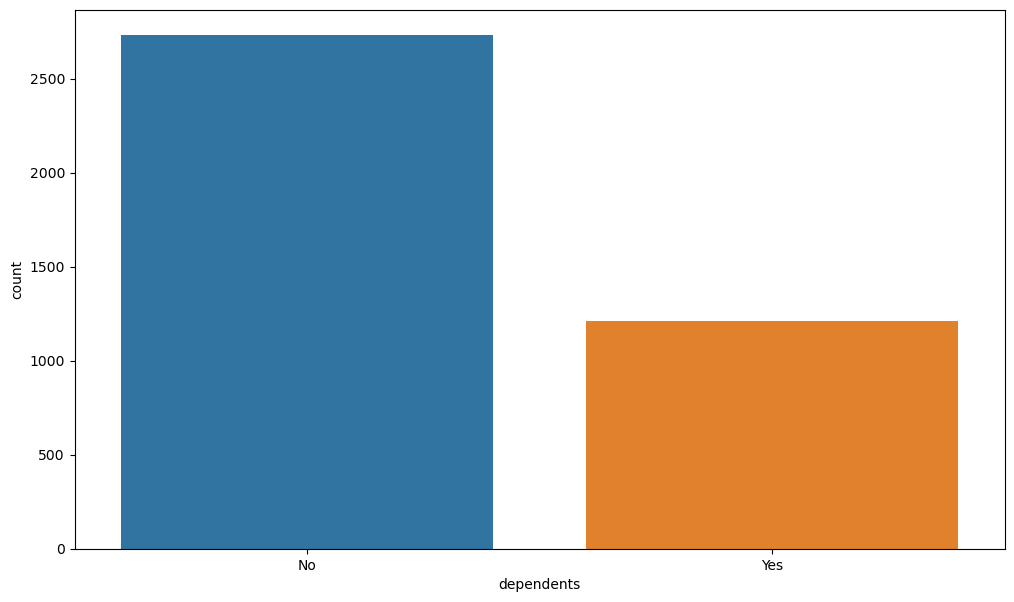

internet_service_type
Fiber optic    44.255643
DSL            34.212529
None           21.531829
Name: internet_service_type, dtype: float64


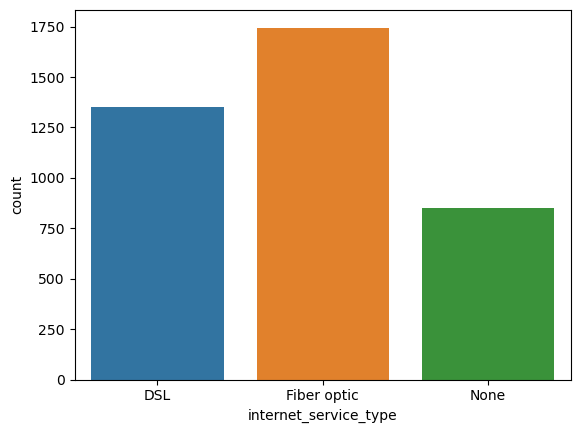

monthly_charges
20.05     0.862288
19.85     0.811565
19.90     0.735481
19.65     0.710119
20.00     0.634035
            ...   
66.85     0.025361
59.05     0.025361
101.60    0.025361
77.15     0.025361
88.20     0.025361
Name: monthly_charges, Length: 1332, dtype: float64


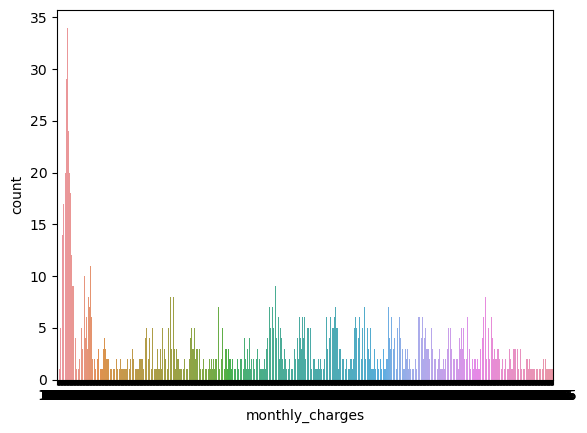

multiple_lines
No                  47.704793
Yes                 43.038296
No phone service     9.256911
Name: multiple_lines, dtype: float64


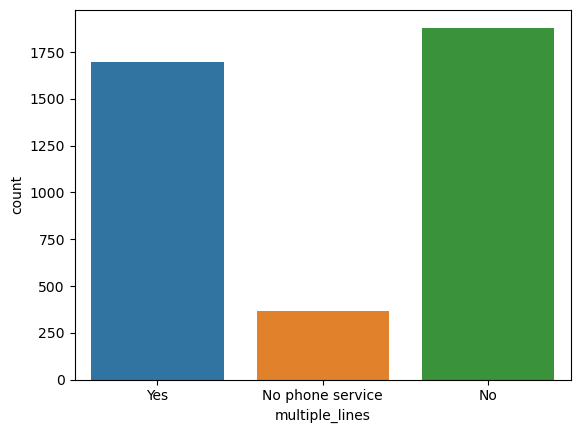

partner
No     51.331473
Yes    48.668527
Name: partner, dtype: float64


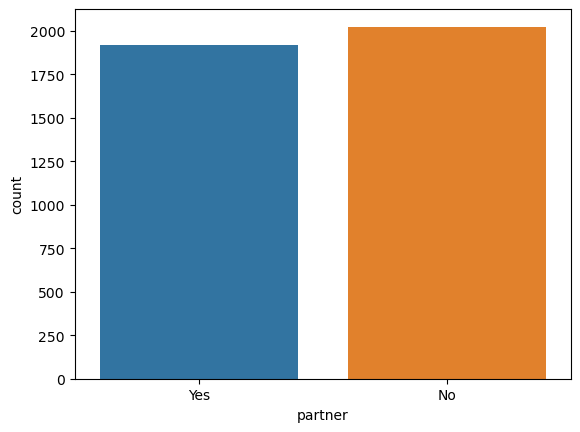

tech_support
No                     49.175755
Yes                    29.292417
No internet service    21.531829
Name: tech_support, dtype: float64


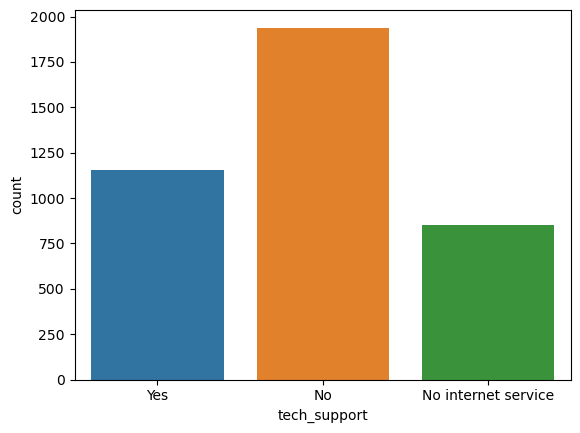

contract_type
Month-to-month    55.034238
Two year          23.433934
One year          21.531829
Name: contract_type, dtype: float64


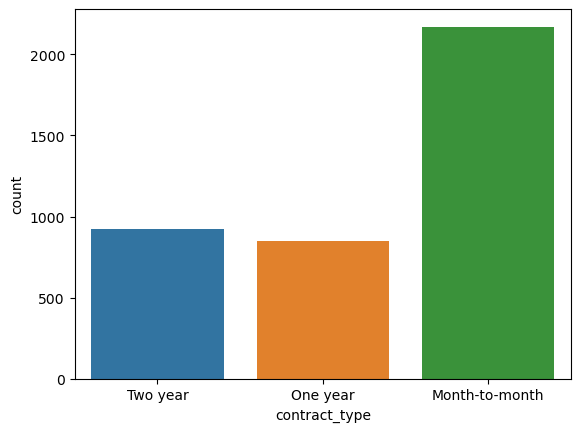

In [14]:
# Now let's visualize all of our categorical variable counts
plt.figure(figsize=(12,7))
for col in cats:
    print(col)
#     print(train[col].value_counts())
    print(train[col].value_counts(normalize=True)*100)
    sb.countplot(x=col, data=train)
    plt.show()

#### It looks like most of our contract types are mont-to-month/short term contracts

Month-to-month    2170
Two year           924
One year           849
Name: contract_type, dtype: int64


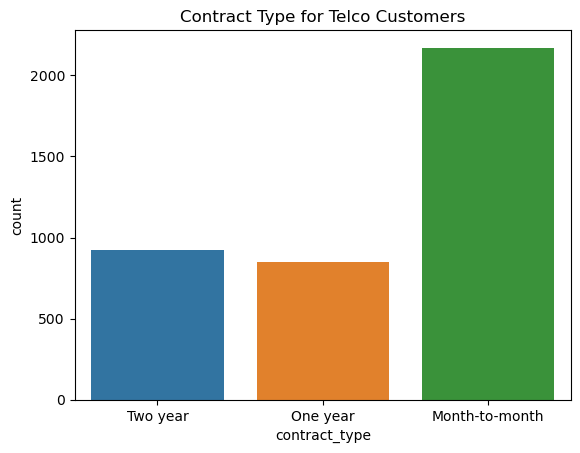

In [15]:
print(train['contract_type'].value_counts())
sb.countplot(x='contract_type',data=train)
plt.title('Contract Type for Telco Customers')
plt.show()

### Bivariate Analysis

<AxesSubplot:>

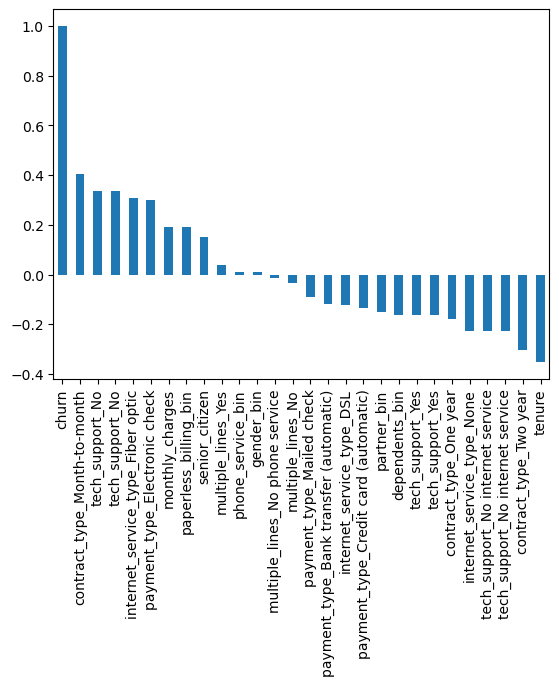

In [16]:
# Visualizing how our nb categories correlate with churn

telco.corr()['churn'].sort_values(ascending= False).plot(kind = 'bar')

## Question 1: Churn Down for What?
## On average, are customers who churn paying a higher monthly bill than customers who stay?


The first thing I'm interested in looking at is how the monthly charges of churned customers compares with the monthly charges of current customers. 
#### I believe that higher monthly costs may be contributing to higher customer churn rates. 
I'm adding an additional metric called 'monthlycats' which will split the monthly charges into 3 distinct categories: high cost, mid cost, low cost

In [17]:
# A breakdown of how my monthly charges tiers are broken up 
monthlycats = pd.cut(train['monthly_charges'],3)
monthlycats.value_counts()

(51.75, 85.25]     1356
(18.15, 51.75]     1350
(85.25, 118.75]    1237
Name: monthly_charges, dtype: int64

## Q1.Chart1

#### Observations:
This chart takes a look at what tier of monthly charges our customers have paid over a 50 month period. It appears that among customers who churned, most of them were paying between 50.70 - 118.75 before leaving. 

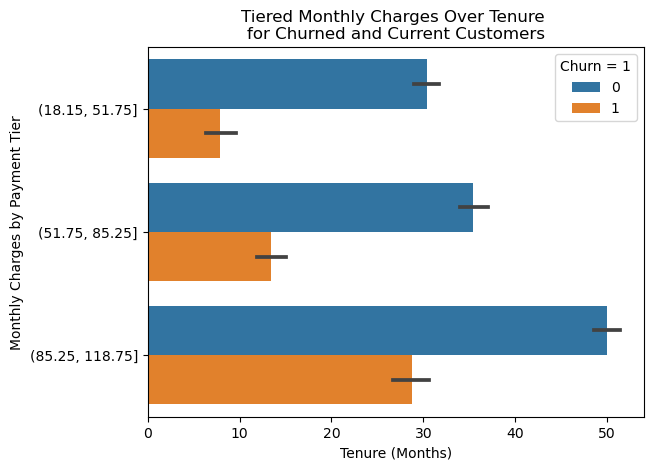

In [18]:
sb.barplot(x='tenure', y=monthlycats, hue='churn', data=train)
plt.xlabel('Tenure (Months)')
plt.ylabel('Monthly Charges by Payment Tier')
plt.title('''Tiered Monthly Charges Over Tenure 
for Churned and Current Customers''')
plt.legend(title='Churn = 1')
plt.show()

## Q1.Chart2

#### Observations:
This chart takes a look at what tier of monthly charges our customers have paid without controlling for time. It appears that among customers who churned, most of them were paying between 50.70 - 118.75 before leaving while most current customers are paying within the low tier cost range. This graph has the potential to be misleading, so I'll evaluate one final way.

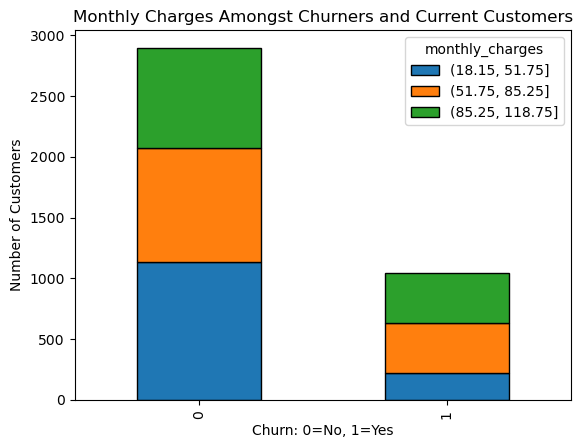

In [19]:
train.groupby(['churn', monthlycats])['tenure'].count().unstack().plot(kind='bar', edgecolor='black', stacked=True)
plt.xlabel('Churn: 0=No, 1=Yes')
plt.ylabel('Number of Customers')
plt.title('Monthly Charges Amongst Churners and Current Customers')
plt.show()

## Q1.Chart3

#### Observations:
This chart takes a look at the total monthly charges our customers have paid over a 75 month period. Customers who churned appear to have a higher monthly average than customers who didn't churn.

Text(0.5, 1.0, 'Monthly Charges for Churned & Current Customers Over 70 Month Tenure')

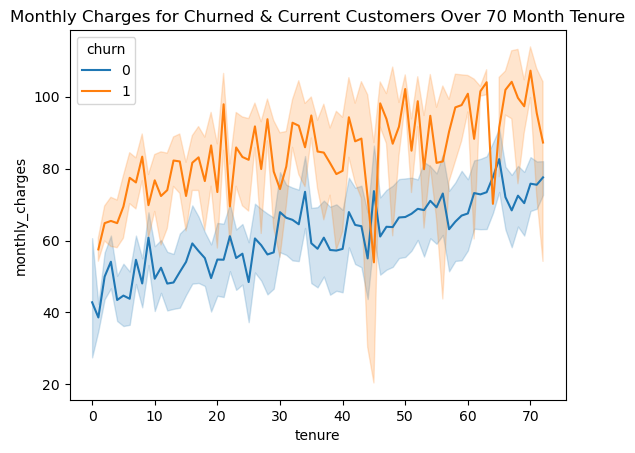

In [20]:
sb.lineplot(x='tenure', y='monthly_charges', hue='churn', data=train)
plt.title('Monthly Charges for Churned & Current Customers Over 70 Month Tenure')


## Q1. Hypothesis Testing

### Hypotheses 

Q1 Hypothesis: The average monthly charges for a churned customer are greater than the average monthly charges for a current customer. 

Q1 Null Hypothesis: The average monthly charges for a churned customer are less than or equal to the average monthly charges for a current customer. 

a= 0.05

### Test Type: T-Test

Hypotheses testing calls for a one-tailed t-test. The hypothesis asks us to consider a sample group from a larger overall group (1 sample) and posits that there will be a significant difference (*greater than*) between them.




In [21]:
# Subset the data to separate churned and non-churned customers
churned = train[train["churn"] == 1].monthly_charges
current_customers = train[train["churn"] == 0].monthly_charges
tr_mean = train['monthly_charges'].mean()
a= 0.05

# Perform the two-sample t-test
t_stat, p_value = ttest_1samp(churned, tr_mean)

print("The t-statistic is: ", t_stat)

# Divide p_value by 2
print("The p-value is: ", p_value/2)

The t-statistic is:  12.255311980286635
The p-value is:  1.1634577282298712e-32


In [22]:
if p_value/2 < a and t_stat > 0:
    print("We reject the null hypothesis")
elif t_stat < 0 or p_value/2 > a:
    print("We fail to reject the null hypothesis")


We reject the null hypothesis


### Q1.Results

1. p-value/2 < a *and* t-stat > 0
2. We can reject the null hypothesis, which suggests that customers who churned have a higher average monthly cost than customers who still subscribe.





## Question 2: Hotline Bling
## Is there a relationship between how many lines a customer has on their phone plan and their likeliness to churn?

### Q2.Table1

In [23]:
line_churn = train.pivot_table(index='churn', columns='multiple_lines',
values='tenure', aggfunc='count')
line_churn

multiple_lines,No,No phone service,Yes
churn,,,
0,1406,273,1218
1,475,92,479


In [24]:
# Add the Number of customers and churners with multiple lines, then divide by total (3943) 
a =round((1218+479)/3943, 2)

# Add the Number of customers and churners with multiple lines, then divide by total (3943) 
b =round((1406 + 475)/3943,2)

# Add the Number of customers and churners with no service, then divide by total (3943) 
c = round((273+92)/3943, 2)

print(f'Percentage of customers & churners with multiple lines:{a:.2%}')
print(f'Percentage of customers & churners without multiple lines:{b:.2%}')
print(f'Percentage of customers & churners without phone service:{c:.2%}')

Percentage of customers & churners with multiple lines:43.00%
Percentage of customers & churners without multiple lines:48.00%
Percentage of customers & churners without phone service:9.00%


#### Observations:
Looking at the pivot table above, it looks like there isn't a lot of difference between customers who don't churn have multipling lines on their phone plans compared to customers who do churn. Customers with multiple lines account for 43% of the customer base, while customers without multiple lines account for slightly more a 48%. Customers without phone service make up 9% of the dataframe. 28% of customers with multiple lines churn, and 25% of customers without multiple lines churn. The following plots will give us better visual representation of this data.

### Q2.Chart1

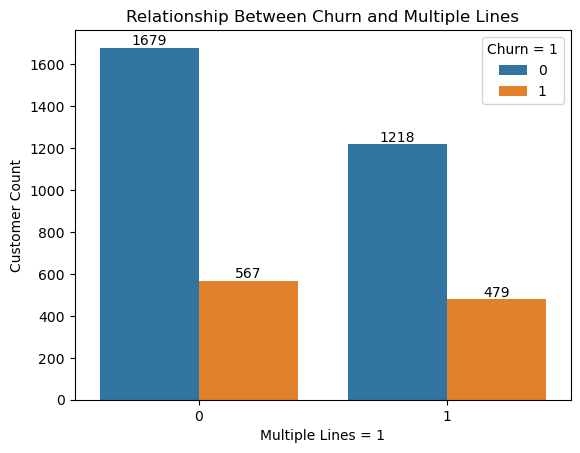

In [25]:
ax = sb.countplot(x='multiple_lines_Yes', hue= 'churn',data=train)
plt.xlabel('Multiple Lines = 1')
plt.ylabel('Customer Count')
plt.title('''Relationship Between Churn and Multiple Lines''')
plt.legend(title='Churn = 1')
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

#### Observations:
We can see that customers with multiple lines have a slightly smaller rate of churn in this dataframe than customers who don't. Next, a test for correlation will be performed on the variables using Pearson's R method.

### Q2. Hypothesis Testing

### Hypothesis
Q2 Hypthesis: Customers who have multiple lines are less likely to churn than customers who do not have multiple lines.

Q2 Null Hypothesis: Customers who have multiple lines are not less likely to churn than customers who do not have multiple lines

### Test Type: T-Test

- Variables measured: churn, multiple_lines
- Values returned: t-value, p-value
- a = 0.05

In [26]:
a= 0.05
corr, p = stats.pearsonr(train.multiple_lines_Yes, train.churn)
if p < a:
    print(f'''The correlation between customers having multiple lines and churning is 
    {corr} and the p-value is {p}.''')
    print('We reject the null hypothesis')
else:
    print(f'''The correlation between customers having multiple lines and churning is {corr} 
    and the p-value is {p}.''')  
    print('We fail to reject the null hypothesis')



The correlation between customers having multiple lines and churning is 
    0.03343691716506561 and the p-value is 0.035769669844533405.
We reject the null hypothesis


### Results
- p-value < a
- We can reject the null hypothesis, which suggests that customers who churned have a higher average monthly cost than customers who still subscribe.


## Question 3: What are we? Churn vs Relationships
Within the dataframe, there are two metrics which measure family dynamics: dependents and partner. I"m interested in discovering if *families are less likely to churn than customers without families.*

### Q3. Table 1

In [27]:
deps= pd.crosstab(train['dependents'], train['churn'])
deps

churn,0,1
dependents,,
No,1871,859
Yes,1026,187


### Q3. Table 2

In [28]:
ring =pd.crosstab(train['partner'], train['churn'])
ring

churn,0,1
partner,,
No,1349,675
Yes,1548,371


#### Observations:
- Only 15.4% of customers with dependents churned vs. 31.5% of customers without dependents
- Only 19.3% of customers with partners churned vs. 33.3% of customers without partners

### Q3. Chart 1 

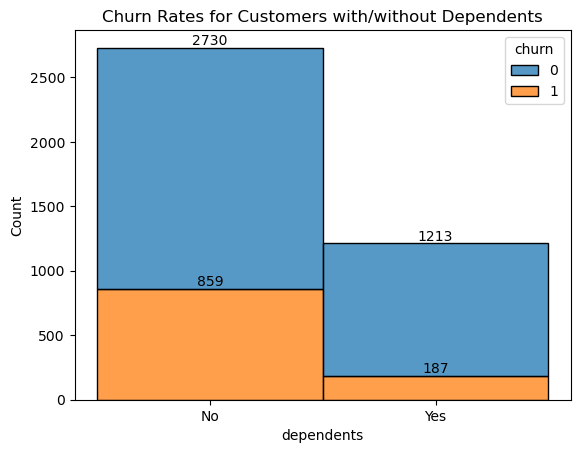

In [29]:
ax = sb.histplot(data=train, x='dependents', hue='churn', multiple='stack')
plt.title('Churn Rates for Customers with/without Dependents')
for i in ax.containers:
    ax.bar_label(i,)

### Q3. Chart 2

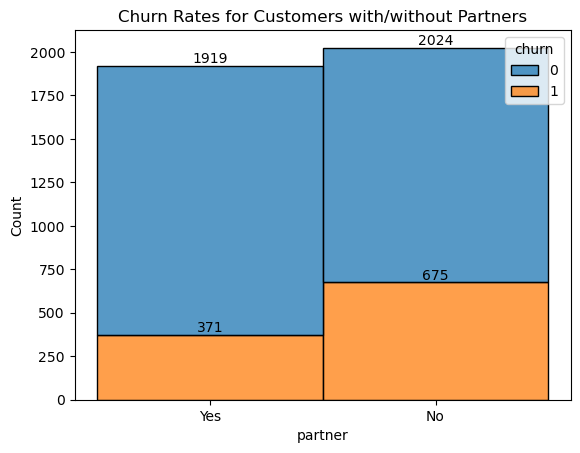

In [30]:
ax = sb.histplot(data=train, x='partner', hue='churn', multiple='stack')
plt.title('Churn Rates for Customers with/without Partners')
for i in ax.containers:
    ax.bar_label(i,)

## Q3. Hypothesis Testing

### Hypotheses Testing

Q3 Hypothesis: Customers with dependents or significant others are less likely to churn than customers who are single 

Q3 Null Hypothesis: Customers with dependents or significant others are as no more or less likely to churn than customers who are single 

### Test Type: Chi-Squared

- Variables measured: partner, dependents, churn 
- Values returned: chi2, p-value, degree of freedom, expected values

#### Dependents & Churn

In [31]:
a=0.05
chi2, p, degf, expected = stats.chi2_contingency(deps)
chi_deps =chi2, p, degf, expected
chi_deps

# print 'Observed Values' followed by a new line
print(f'Observed Values: {deps.values}\n')

# print --- and then a new line, 'Expected Values' array as int
print(f'---\nExpected Values: {expected.astype(int)}\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'---\nchi^2 = {chi2:.4f}') 

# print the p-value
print(f'p     = {p}')

if p< a:
    print(f''' Observed Values: {deps.values}''')
    print('We reject the null hypothesis')

Observed Values: [[1871  859]
 [1026  187]]

---
Expected Values: [[2005  724]
 [ 891  321]]

---
chi^2 = 110.1619
p     = 9.030713272299022e-26
 Observed Values: [[1871  859]
 [1026  187]]
We reject the null hypothesis


#### Partners & Churn

In [32]:
chi2, p, degf, expected = stats.chi2_contingency(ring)
chi_part =chi2, p, degf, expected
chi_part

# print 'Observed Values' followed by a new line
print(f'Observed Values: {ring.values}\n')

# print --- and then a new line, 'Expected Values' array as int
print(f'---\nExpected Values: {expected.astype(int)}\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'---\nchi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p}')

if p< a:
    print(f''' Observed Values: {ring.values}''')
    print('We reject the null hypothesis')

Observed Values: [[1349  675]
 [1548  371]]

---
Expected Values: [[1487  536]
 [1409  509]]

---
chi^2 = 98.5779
p     = 3.124807670665349e-23
 Observed Values: [[1349  675]
 [1548  371]]
We reject the null hypothesis


### Q3. Results

1. p-value < a
2. We can reject the null hypothesis, and affirm that customers with families (dependents and/or partners) are less likely to churn than customers who are single

## Question 4: To Churn or not to Churn? 
### Tech Support & Tenure vs Churn
Target question: Do customers churn at a higher rate if they've experienced numerous technical issues within their tenure window? 

### Q4. Chart 1

In [33]:
churn_tech_web = train.pivot_table(index=['internet_service_type', 'tech_support'], columns=['churn'], values='tenure')
churn_tech_web

churn                                              0          1
internet_service_type tech_support                             
DSL                   No                   28.012146  11.473404
                      Yes                  44.710483  20.893939
Fiber optic           No                   36.133436  18.424793
                      Yes                  52.553134  33.239669
None                  No internet service  32.321839   7.181818

In [34]:
pre_chi = pd.crosstab(train['churn'], [train['tech_support'], train['internet_service_type']])
pre_chi

tech_support            No             No internet service  Yes            
internet_service_type  DSL Fiber optic                None  DSL Fiber optic
churn                                                                      
0                      494         652                 783  601         367
1                      188         605                  66   66         121

#### Observations:
- Fiber optic users who used tech support have the highest churn rate
- Most telco customers are using our internet service

### Q4. Table 1

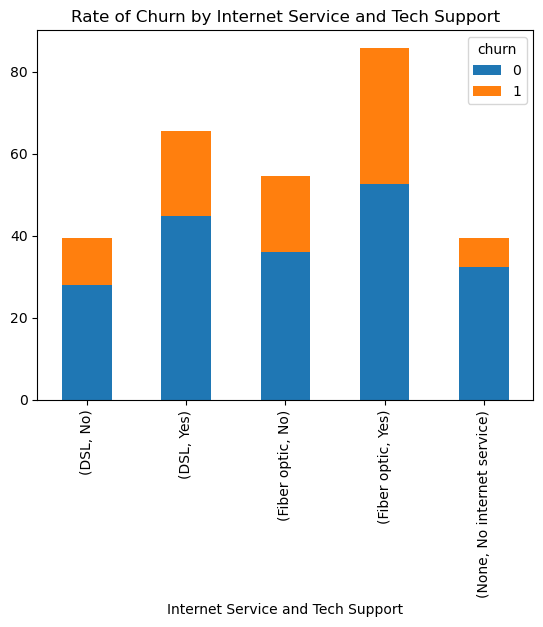

In [35]:
churn_tech_web.plot(kind='bar', stacked=True)

plt.xlabel('Internet Service and Tech Support')
plt.ylabel('')
plt.title('Rate of Churn by Internet Service and Tech Support')

plt.show()

### Q4. Table 2

Text(0.5, 1.0, 'Customer Use of Tech Support over 70 Months')

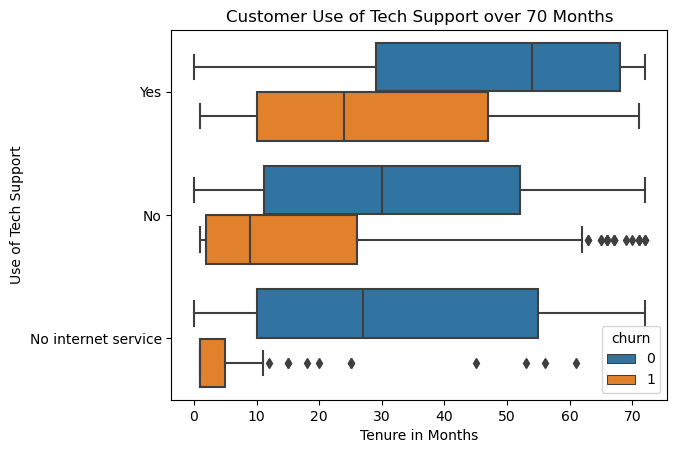

In [36]:
sb.boxplot(x='tenure', y='tech_support', hue='churn', data=train,)
plt.xlabel('Tenure in Months')
plt.ylabel('Use of Tech Support')
plt.title('Customer Use of Tech Support over 70 Months')

#### Obesrvations:
I opted to include customers who don't use the internet services or recieve technical support. Seeing the low churn rate for non-internet customers reaffirms my belief that internet service is a high-impact indicator of churn.

It appears that customers who've churned also relied more heavily on tech support- especially amongst fiber optic internet users. This could suggest some frustrations amongst users with the reliability and accessability of telco's internet connectivity.

### Q4. Hypothesis Testing

#### Hypothesis
Hypothesis: Customers who experience documented technical issues with their internet service over their tenure are more likely to churn than customers who don't rely heavily on tech support.
Null Hypothesis: Customers who experience documented technical issues with their internet service over their tenure are less likely or just as likely to churn as customers who don't rely heavily on tech support.

#### Test Type: Chi-square
Variables measured: internet_service_type, churn, tenure, tech_support
Values returned: chi-sq, degrees of freedom, p-value, expected frequencies

In [37]:
from scipy.stats import chi2_contingency

a=0.05
stat, p, dof, expected = chi2_contingency(pre_chi)

print(f"Chi-square statistic: {stat}")

print(f"P-value: {p}")

print(f"Degrees of freedom: {dof}")

print("Expected frequencies:")
print(expected)

if p< a:
    print('We reject the null hypothesis')

Chi-square statistic: 549.9750037763221
P-value: 1.0359403591791008e-117
Degrees of freedom: 4
Expected frequencies:
[[501.07887395 923.54273396 623.77707329 490.05807761 358.54324119]
 [180.92112605 333.45726604 225.22292671 176.94192239 129.45675881]]
We reject the null hypothesis


#### Results:
- p < a
- We reject the null hypothesis that customers who experience documented technical issues with their internet service are less likely or just as likely to churn as customers who don't rely heavily on tech support.
- Customers who churned reported more technical issues leading up to their departure for telco.

## Question 5: Commitment Issues
### Contract Type vs Churn
The following section will be dedicated to exploring how different contract types may effect a customer's probability to churn. Specifically, I want to know how month-to-month contracts affect the likeliness to churn.
Target question: Are month-to-month customers more likely than long term customers to churn?

### Q5. Table 1

In [38]:
pd.crosstab(train['churn'], train['contract_type'])
                             

contract_type,Month-to-month,One year,Two year
churn,,,
0,1249,753,895
1,921,96,29


#### Observations:
- With a total of 2,170, customers with month-to-month contracts make up the majority of contract types for telco
- Total One year contracts: 849
- Total Two year contracts: 924

### Q5. Chart 1

Text(0.5, 1.0, 'Monthly Charges for Churned & Current Customers by Contract Type')

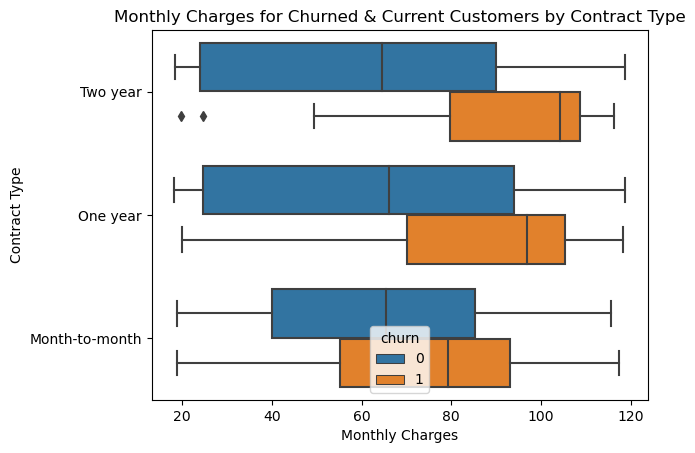

In [39]:
sb.boxplot(x='monthly_charges', y='contract_type', hue='churn', data=train)
plt.xlabel('Monthly Charges')
plt.ylabel('Contract Type')
plt.title('Monthly Charges for Churned & Current Customers by Contract Type')

#### Observations:
- The range for month-to-month customers appears smaller than the range of 1 yr or 2 yr customers
- The average monthly charges for momnth-to-month customers that churn is around $80 vs around $64 for month-to-month customers who don't churn
- Two and one year customers appear to pay higher average monthly charges than m2m customers when they churn
- All contract groups have similar average monthly charges for customers who choose to stay

([<matplotlib.axis.XTick at 0x7f88416a0250>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

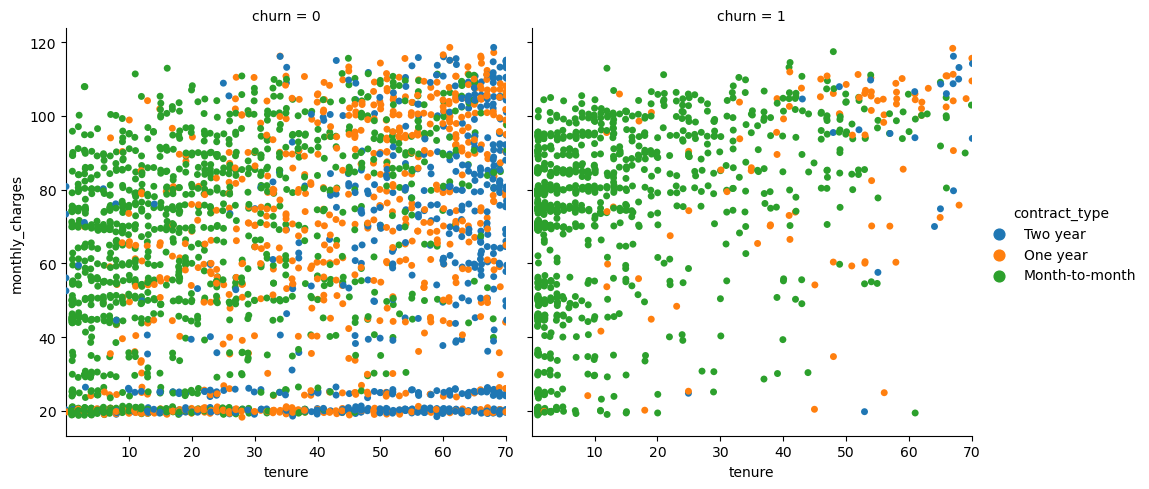

In [40]:
sb.catplot(x='tenure', y='monthly_charges', hue='contract_type', col='churn', data=train)
plt.xlim(0, 70)
plt.xticks([10, 20, 30, 40, 50, 60, 70])

#### Observations:
- Most of the customers who churned were month-to-month (m2m) customers. That's to be expected, since they make up the most common contract type. 

### Hypothesis Testing

#### Hypotheses

Null Hypothesis: Month to month customers are not any more likely than long term customers to churn
Hypothesis: Month-to-month customers are more likely to churn than long term customers

Test Type: Chi-square

Variables measured: internet_service_type, churn, tenure, tech_support Values returned: chi-sq, degrees of freedom, p-value, expected frequencies

In [41]:
# Subset the data into survived and not-surviving status
bye = train[train.churn == 1]
stay = train[train.churn == 0]


In [42]:
# check variances of the two groups
bye['contract_type_Month-to-month'].var(), stay['contract_type_Month-to-month'].var()

#Not that much variance, so won't use Mann Whitney

(0.10532262343674238, 0.24534239077575012)

In [43]:

a = 0.05
noneofyour_conchurn = pd.crosstab(train['contract_type'], train['churn'])
chi2, p, degf, expected = stats.chi2_contingency(noneofyour_conchurn)
print(f'''Chi-Squared: {chi2}, 
          P-value :{p}, 
          Degree of Freedom:{degf}, 
          Expected:{expected}''')
if p < a:
    print( 'We can reject the null hypothesis')

Chi-Squared: 642.2389450098603, 
          P-value :3.4640572380016525e-140, 
          Degree of Freedom:2, 
          Expected:[[1594.34187167  575.65812833]
 [ 623.77707329  225.22292671]
 [ 678.88105503  245.11894497]]
We can reject the null hypothesis


### Results
- p < a
- We can reject the null hypothesis and assume that month to month customers are more likely to churn than long term customers

## MODELING
Now that we've explores potential drivers for churn, it's time to fit them for modeling.

### Model Prep: Baseline
Baseline predictions are based off of which occurance happens most frequently. Therefore:
- Baseline prediction: No Churn

Next, we will test the accuracy of this prediction.

In [44]:
base_pred = (train.churn == 0)
base_acc = base_pred.mean()
print(f'Baseline Accuracy:{base_acc:.2%}')

Baseline Accuracy:73.47%


In [45]:
base_pred.value_counts()

True     2897
False    1046
Name: churn, dtype: int64

In [46]:
# Set variables for model fitting
X_train, y_train, X_val, y_val, X_test, y_test = wr.model_setup(train, val, test)

In [47]:
X_train.shape

(3943, 9)

In [48]:
train.churn.value_counts()

0    2897
1    1046
Name: churn, dtype: int64

In [49]:
# Subset the data into churn and not churn status
churn_yes = train[train.churn == 1]
churn_no = train[train.churn == 0]


#### Features Kept for Modeling

- churn                
- tenure              
- monthly_charges      
- dependents           
- partner
- internet_service_type
- multiple lines
- tech_support 

### Model 1: Decision Tree (Train/test)

In [50]:
# make the thing
treebeard = DecisionTreeClassifier(max_depth=3, random_state= 123)

# fit the thing
m1fit =treebeard.fit(X_train, y_train)

# predict the thing
y_pred= treebeard.predict(X_train)

# actual/non-predicted thing
actual = y_train

y_pred_test = treebeard.predict(X_test)

[Text(0.5, 0.875, 'contract_type_Month-to-month <= 0.5\ngini = 0.39\nsamples = 3943\nvalue = [2897, 1046]\nclass = 0'), Text(0.25, 0.625, 'monthly_charges <= 93.775\ngini = 0.131\nsamples = 1773\nvalue = [1648, 125]\nclass = 0'), Text(0.125, 0.375, 'monthly_charges <= 41.35\ngini = 0.073\nsamples = 1315\nvalue = [1265, 50]\nclass = 0'), Text(0.0625, 0.125, 'gini = 0.03\nsamples = 601\nvalue = [592, 9]\nclass = 0'), Text(0.1875, 0.125, 'gini = 0.108\nsamples = 714\nvalue = [673, 41]\nclass = 0'), Text(0.375, 0.375, 'tenure <= 67.5\ngini = 0.274\nsamples = 458\nvalue = [383, 75]\nclass = 0'), Text(0.3125, 0.125, 'gini = 0.34\nsamples = 290\nvalue = [227, 63]\nclass = 0'), Text(0.4375, 0.125, 'gini = 0.133\nsamples = 168\nvalue = [156, 12]\nclass = 0'), Text(0.75, 0.625, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.489\nsamples = 2170\nvalue = [1249, 921]\nclass = 0'), Text(0.625, 0.375, 'tenure <= 5.5\ngini = 0.405\nsamples = 977\nvalue = [701, 276]\nclass = 0'), Text(0.5625, 0.12

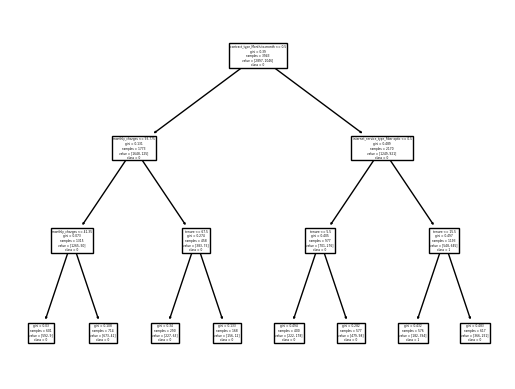

In [51]:
# Visualization of decision tree
print(plot_tree(treebeard, feature_names= X_train.columns, class_names=['0','1']))

In [52]:
#That's horrendous. Let's try export_text. s/o to stackoverflow

print(export_text(treebeard, feature_names=X_train.columns.tolist()))

|--- contract_type_Month-to-month <= 0.50
|   |--- monthly_charges <= 93.78
|   |   |--- monthly_charges <= 41.35
|   |   |   |--- class: 0
|   |   |--- monthly_charges >  41.35
|   |   |   |--- class: 0
|   |--- monthly_charges >  93.78
|   |   |--- tenure <= 67.50
|   |   |   |--- class: 0
|   |   |--- tenure >  67.50
|   |   |   |--- class: 0
|--- contract_type_Month-to-month >  0.50
|   |--- internet_service_type_Fiber optic <= 0.50
|   |   |--- tenure <= 5.50
|   |   |   |--- class: 0
|   |   |--- tenure >  5.50
|   |   |   |--- class: 0
|   |--- internet_service_type_Fiber optic >  0.50
|   |   |--- tenure <= 15.50
|   |   |   |--- class: 1
|   |   |--- tenure >  15.50
|   |   |   |--- class: 0



In [53]:
#This variable makes predictions on X_train/in sample data
print(y_pred)
print(y_pred.shape)

[0 0 0 ... 0 0 0]
(3943,)


#### Confusion Matrixes

In [54]:
# Matrix for train data
neo = confusion_matrix(actual, y_pred)
# Matrix for test data
trinity= confusion_matrix(y_test, y_pred_test)

In [55]:
print(neo)
print('-----')
print(trinity)

[[2715  182]
 [ 652  394]]
-----
[[976  59]
 [224 150]]


In [56]:
# Assigning variables for confusion matrix
TN, FP, FN, TP = neo[1,1], neo[0,1], neo[1,0], neo[0,0]

In [57]:
TN, FP, FN, TP

(394, 182, 652, 2715)

In [58]:
# Assigning variables for evaluation

All = TN + FP+ FN+ TP

accuracy= (TP + TN) / All
True_pos_rate = recall= TP/ (TP + FN)
precision = TP/ (TP + FP)
support_pos = TP + FN
support_neg = FP +TN

In [59]:
m1class = pd.DataFrame(classification_report(actual, y_pred, output_dict=True))
m1class

,0,1,accuracy,macro avg,weighted avg
precision,0.806356,0.684028,0.788486,0.745192,0.773905
recall,0.937176,0.376673,0.788486,0.656925,0.788486
f1-score,0.866858,0.485820,0.788486,0.676339,0.765776
support,2897.000000,1046.000000,0.788486,3943.000000,3943.000000


In [60]:
print(f'Baseline Prediction: Not Churn')
print(f'Baseline Accuracy:{base_acc:.2%}')
print('---------')
print(f'''Model 1 Confusion Matrix:
         {neo}''')
print('---------')
print(f'''Model 1 Classification Report:
      {m1class}''')


Baseline Prediction: Not Churn
Baseline Accuracy:73.47%
---------
Model 1 Confusion Matrix:
         [[2715  182]
 [ 652  394]]
---------
Model 1 Classification Report:
                           0            1  accuracy    macro avg  weighted avg
precision     0.806356     0.684028  0.788486     0.745192      0.773905
recall        0.937176     0.376673  0.788486     0.656925      0.788486
f1-score      0.866858     0.485820  0.788486     0.676339      0.765776
support    2897.000000  1046.000000  0.788486  3943.000000   3943.000000


In [61]:
# Evaluate Model 1 Test Data

# Assigning variables for confusion matrix
TN,
FP, 
FN, 
TP = trinity[1,1], trinity[0,1], trinity[1,0], trinity[0,0]

# Assigning variables for evaluation

All = TN + FP+ FN+ TP

accuracy= (TP + TN) / All
True_pos_rate = recall= TP/ (TP + FN)
precision = TP/ (TP + FP)
support_pos = TP + FN
support_neg = FP +TN

In [62]:
# Model 1 Confusion matrix, test data
trinity

array([[976,  59],
       [224, 150]])

In [63]:
m1class_test =pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

In [64]:
m1class_test

,0,1,accuracy,macro avg,weighted avg
precision,0.813333,0.717703,0.799148,0.765518,0.787950
recall,0.942995,0.401070,0.799148,0.672032,0.799148
f1-score,0.873378,0.514580,0.799148,0.693979,0.778140
support,1035.000000,374.000000,0.799148,1409.000000,1409.000000


#### Observations

Model 1(Decision Tree) has a 78.85% accuracy rate on train data, which is a 5.38% higher performance than the baseline accuracy of 73.47%

Model 1(Decision Tree) has a 79.91% accuracy rate on test data, which is a 6.44% higher performance than the baseline accuracy of 73.47%

I should probalby look at how other max depths perform before going on with this one

In [65]:
#Varying accuracies of train set based on max depth
wr.dt_change_depth(X_train, y_train)

Decision Tree depth: 1
                     0       1  accuracy    macro avg  weighted avg
precision     0.734720     0.0   0.73472     0.367360      0.539813
recall        1.000000     0.0   0.73472     0.500000      0.734720
f1-score      0.847076     0.0   0.73472     0.423538      0.622363
support    2897.000000  1046.0   0.73472  3943.000000   3943.000000
Decision Tree depth: 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.854182     0.540654   0.75932     0.697418      0.771009
recall        0.810839     0.616635   0.75932     0.713737      0.759320
f1-score      0.831946     0.576150   0.75932     0.704048      0.764089
support    2897.000000  1046.000000   0.75932  3943.000000   3943.000000
Decision Tree depth: 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.806356     0.684028  0.788486     0.745192      0.773905
recall        0.937176     0.376673  0.788486     0.656925      0.788486
f1-scor

#### Observations
All of my models where max_depth > 2 have accuracy rates above my baseline.
All of my models have less than 5% variance between my train and test accuracy.
DT 2, which carries a max depth of three, is showing signs of being slightly overfit (negative difference). DT 3 has the highest train/test accuracies with the smallest difference

Best= DT 3 with max depth of 4


### Model 2: Random Forest (Train/test)

In [66]:
# fit a Random Forest classifier
sherwood = RandomForestClassifier()

m2fit = sherwood.fit(X_train, y_train)
    
# make predictions on the test set
m2y_pred = sherwood.predict(X_test)

# calculate model score
score = sherwood.score(X_test, y_test)

In [67]:
# I want to be able to compare a multitude of accuracy scores all at once, so I created this function. 
# The areas that are commented out are other calculators that I decided not to use. I'll add it to my
# wrangle.py. I'll make a similar function for my train/val datasets
def rt_multi_test(X_train, y_train, X_test, y_test):
    """This function takes in the train and test datasets and computes their respective
    accuracy scores and the difference between those scores when the max_depth and min_samples
    are changed"""
    little_john=[]
    # set range for max_Depth starting at 1, up to 15, counting by 2
    for i in range(1,15,2):
    # set range forin_samples starting at 3, up to 20, counting by 3
        for x in range(3,20,3):
    # fit a Random Forest classifier
            sherwood = RandomForestClassifier(max_depth= i, min_samples_leaf= x, random_state=123)

            rftestfit = sherwood.fit(X_train, y_train)

    # make predictions on the test set
            rftest_pred = sherwood.predict(X_train)

    # calculate model scores
            test_score = sherwood.score(X_test, y_test)
            train_score= sherwood.score(X_train, y_train)
            difference = round((train_score - test_score) * 100, 2)

    #             reloaded= confusion_matrix(y_train, rftest_pred)    
    #             # Assigning variables for confusion matrix
    #             TN,
    #             FP, 
    #             FN, 
    #             TP = reloaded[1,1], reloaded[0,1], reloaded[1,0], reloaded[0,0]
    #             All = TN + FP+ FN+ TP
    #             accuracy= (TP + TN) / All
    #             True_pos_rate = recall= TP/ (TP + FN)
    #             precision = TP/ (TP + FP)
    #             support_pos = TP + FN
    #             support_neg = FP +TN

            labels = {'max_depth': i,
                           'min_samples_leaf': x,
                           'Train Accuracy': train_score,
                           'Test Accuracy': test_score,
                           'Percentage Difference': difference
                           }
    # create df that measures train score, test score, and the difference between them
            little_john.append(labels)
    return pd.DataFrame(little_john)



# print(f'''Random Forest Accuracy score on test data with max depth of {i}
#          and {x} mins_samples_leaves: {score:.2%}''')
# # print(f'Classification Report classification_rep)
# print(f'Confusion Matrix: {reloaded}')

In [68]:
rt_multi_test(X_train, y_train, X_test, y_test)

,max_depth,min_samples_leaf,Train Accuracy,Test Accuracy,Percentage Difference
0,1,3,0.734720,0.734564,0.02
1,1,6,0.734720,0.734564,0.02
2,1,9,0.734720,0.734564,0.02
3,1,12,0.734720,0.734564,0.02
4,1,15,0.734720,0.734564,0.02
5,1,18,0.734720,0.734564,0.02
6,3,3,0.789247,0.799148,-0.99
7,3,6,0.789247,0.799148,-0.99
8,3,9,0.789247,0.799148,-0.99
9,3,12,0.788993,0.799858,-1.09


**Observations**

- My max depth seems to play a bigger role than my sample leaves, especially in cases of smaller max depths.
- Besides instances where my max depth is 0, all other models have scores that are above my baseline
- There are quite a few instances where my test score is better than my train score
- Model 12- with a max depth of 5 and 3 sample leaves - has the least variance in score accuracy and will be the model that I continue forward with

### Model 3: KNEIGHBOR (Train/test)

#### Train Data Evaluation

In [70]:
wr.knn_train(X_train, y_train)

Model with 5 neighbors:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.71      0.73      3943
weighted avg       0.79      0.80      0.79      3943

---------------
Model with 6 neighbors:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.71      0.73      3943
weighted avg       0.79      0.80      0.79      3943

---------------
Model with 7 neighbors:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75 

In [70]:
wr.knn_train(X_train, y_train)

Model with 5 neighbors:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.71      0.73      3943
weighted avg       0.79      0.80      0.79      3943

---------------
Model with 6 neighbors:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.71      0.73      3943
weighted avg       0.79      0.80      0.79      3943

---------------
Model with 7 neighbors:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75 

#### KNN Train Score vs Test Score

In [71]:

def knn_multi_test(X_train, y_train, X_test, y_test):
    """This function takes in the train and test datasets and computes their respective
    accuracy scores and the difference between those scores when the number of neighbors is
    changed"""
    wont_you_be=[]
    # set range for n_neighbors starting at 5, up to 20
    for i in range(5,20):
    # fit a Random Forest classifier
            nextdoor = KNeighborsClassifier(n_neighbors= i)

            knnfit = nextdoor.fit(X_train, y_train)

    # make predictions on the test set
            y_pred = nextdoor.predict(X_train)

    # calculate model scores
            test_score = nextdoor.score(X_test, y_test)
            train_score= nextdoor.score(X_train, y_train)
            difference = round((train_score - test_score) * 100, 2)

            labels = {'n_neighbors': i,
                           'Train Accuracy': train_score,
                           'Test Accuracy': test_score,
                           'Percentage Difference': difference
                           }
    # create df that measures train score, test score, and the difference between them
            wont_you_be.append(labels)
    return pd.DataFrame(wont_you_be)

In [72]:
knn_multi_test(X_train, y_train, X_test, y_test)

,n_neighbors,Train Accuracy,Test Accuracy,Percentage Difference
0,5,0.838955,0.773598,6.54
1,6,0.827035,0.784244,4.28
2,7,0.828303,0.777147,5.12
3,8,0.817905,0.782825,3.51
4,9,0.817652,0.778566,3.91
5,10,0.813594,0.784954,2.86
6,11,0.806746,0.785664,2.11
7,12,0.805985,0.788502,1.75
8,13,0.806746,0.786373,2.04
9,14,0.806239,0.794180,1.21


In [73]:
def mr_rogerstest(X_train, y_train, X_test, y_test):
    """using KNearest Neighbor to return accuracy of my target prediction on train and test sets
    """
    
# creating KNN classifier with number of neighbors=5
    knn_classifier = KNeighborsClassifier(n_neighbors = 15)

# fitting the KNN classifier with training data
    knn_classifier.fit(X_train, y_train)

# predicting churn outcome for test data
    y_pred = knn_classifier.predict(X_test)

# getting the model score
    model_score = knn_classifier.score(X_test, y_test)

# getting the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

# getting the classification report
    classification_rep = classification_report(y_test, y_pred)
    
    print(f'Accuracy of KNN on train data: {knn_classifier.score(X_train, y_train)}')
    print(f'Model score/ Accuracy of KNN on test data: {model_score}')
    # print("Model Score: ", model_score)
    print("\nClassification Report:\n", classification_rep)
    print("\nConfusion Matrix:\n", confusion_mat)

In [74]:
mr_rogerstest(X_train, y_train, X_test, y_test)

Accuracy of KNN on train data: 0.8024346943951306
Model score/ Accuracy of KNN on test data: 0.794889992902768

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.79      1409


Confusion Matrix:
 [[934 101]
 [188 186]]


**Observations**
- All of my train and test scores were above my 73% baseline
- The difference between my train and test scores seems to decrease as my number of neighbors increases
- My nearest neighbor model that is most optimal to continue forward with is the *model with 15 neighbors.* Both my train and test scores are high and there's only a .75% difference between the two

### Model 4: Decision Tree (Train/Val)

In [75]:
wr.dt_change_depth(X_train, y_train)

Decision Tree depth: 1
                     0       1  accuracy    macro avg  weighted avg
precision     0.734720     0.0   0.73472     0.367360      0.539813
recall        1.000000     0.0   0.73472     0.500000      0.734720
f1-score      0.847076     0.0   0.73472     0.423538      0.622363
support    2897.000000  1046.0   0.73472  3943.000000   3943.000000
Decision Tree depth: 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.854182     0.540654   0.75932     0.697418      0.771009
recall        0.810839     0.616635   0.75932     0.713737      0.759320
f1-score      0.831946     0.576150   0.75932     0.704048      0.764089
support    2897.000000  1046.000000   0.75932  3943.000000   3943.000000
Decision Tree depth: 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.806356     0.684028  0.788486     0.745192      0.773905
recall        0.937176     0.376673  0.788486     0.656925      0.788486
f1-scor

In [76]:
def dt_comp_train_val(X_train, y_train, X_val, y_val):
    # Make some slight variations to the function I used earlier
    christmas=[]
    for i in range(1,9):
        # make the thing
        tree=DecisionTreeClassifier(max_depth= i, random_state= 123)
        # fit the thing 
        tree.fit(X_train, y_train)
        # use the thing to evaluate model performance
        out_of_sample= tree.score(X_val, y_val)
        in_sample=tree.score(X_train, y_train)
        difference= round((in_sample - out_of_sample) * 100, 2)
        #labeling columns for table
        heads= {'max_depth': {i}, 
                'train_accuracy' : in_sample,
                'val_accuracy' : out_of_sample,
                'train_val_difference' : difference}
        christmas.append(heads)
    willow = pd.DataFrame(christmas)
    return willow


In [77]:
dt_comp_train_val(X_train, y_train, X_val, y_val)

,max_depth,train_accuracy,val_accuracy,train_val_difference
0,{1},0.734720,0.734477,0.02
1,{2},0.759320,0.767002,-0.77
2,{3},0.788486,0.790656,-0.22
3,{4},0.792037,0.795979,-0.39
4,{5},0.800152,0.793022,0.71
5,{6},0.808268,0.787108,2.12
6,{7},0.816130,0.784743,3.14
7,{8},0.827035,0.775281,5.18


#### Observations

- Definitely more overfitting in this train/val vs train/test
- Model 0 has very little train/val difference, but it's also not an improvement on my baseline
- Model 4 returns the highest train accuracy and val accuracy without leaving me with a huge difference

**Best fit:** Model 4 with max_depth of 5

### Model 5: Random Forest (Train/val)

In [78]:
# fit a Random Forest classifier
little_john = RandomForestClassifier()

m5fit = little_john.fit(X_train, y_train)
    
# make predictions on the test set
m5y_pred = sherwood.predict(X_val)

# calculate model score
m5score = sherwood.score(X_val, y_val)

In [79]:
m5score

0.7675931401537551

In [80]:
def rt_multi_val(X_train, y_train, X_val, y_val):
    """This function takes in the train and test datasets and computes their respective
    accuracy scores and the difference between those scores when the max_depth and min_samples
    are changed"""
    little_john=[]
    # set range for max_Depth starting at 1, up to 15, counting by 2
    for i in range(1,15,2):
    # set range forin_samples starting at 3, up to 20, counting by 3
        for x in range(3,20,3):
    # fit a Random Forest classifier
            sherwood = RandomForestClassifier(max_depth= i, min_samples_leaf= x, random_state=123)

            rftestfit = sherwood.fit(X_train, y_train)

    # make predictions on the test set
            rftest_pred = sherwood.predict(X_train)

    # calculate model scores
            val_score = sherwood.score(X_val, y_val)
            train_score= sherwood.score(X_train, y_train)
            difference = round((train_score - val_score) * 100, 2)

            labels = {'max_depth': i,
                           'min_samples_leaf': x,
                           'Train Accuracy': train_score,
                           'Validate Accuracy': val_score,
                           'Percentage Difference': difference
                           }
    # create df that measures train score, test score, and the difference between them
            little_john.append(labels)
    return pd.DataFrame(little_john)

In [81]:
rt_multi_val(X_train, y_train, X_val, y_val)

,max_depth,min_samples_leaf,Train Accuracy,Validate Accuracy,Percentage Difference
0,1,3,0.734720,0.734477,0.02
1,1,6,0.734720,0.734477,0.02
2,1,9,0.734720,0.734477,0.02
3,1,12,0.734720,0.734477,0.02
4,1,15,0.734720,0.734477,0.02
5,1,18,0.734720,0.734477,0.02
6,3,3,0.789247,0.790065,-0.08
7,3,6,0.789247,0.790656,-0.14
8,3,9,0.789247,0.790065,-0.08
9,3,12,0.788993,0.791248,-0.23


**Best fit:** Model 13 with max_depth of 5 and min_Sample_leaf of 6.

- Train accuracy: 79.76%
- Validate accuracy:79.66%
- Difference: .10%

### Model 6: KNeighbors (Train/val)

In [82]:
def knn_multi_val(X_train, y_train, X_val, y_val):
    """This function takes in the train and test datasets and computes their respective
    accuracy scores and the difference between those scores when the number of neighbors is
    changed"""
    wont_you_be=[]
    # set range for n_neighbors starting at 5, up to 25
    for i in range(5,25):
    # fit a Random Forest classifier
            nextdoor = KNeighborsClassifier(n_neighbors= i)

            knnfit = nextdoor.fit(X_train, y_train)

    # make predictions on the test set
            y_pred = nextdoor.predict(X_val)

    # calculate model scores
            val_score = nextdoor.score(X_val, y_val)
            train_score= nextdoor.score(X_train, y_train)
            difference = round((train_score - val_score) * 100, 2)

            labels = {'n_neighbors': i,
                           
                           'Train Accuracy': train_score,
                           'Validate Accuracy': val_score,
                           'Percentage Difference': difference
                           }
    # create df that measures train score, test score, and the difference between them
            wont_you_be.append(labels)
    return pd.DataFrame(wont_you_be)

In [83]:
knn_multi_val(X_train, y_train, X_val, y_val)

,n_neighbors,Train Accuracy,Validate Accuracy,Percentage Difference
0,5,0.838955,0.763454,7.55
1,6,0.827035,0.771733,5.53
2,7,0.828303,0.771733,5.66
3,8,0.817905,0.775281,4.26
4,9,0.817652,0.776464,4.12
5,10,0.813594,0.778829,3.48
6,11,0.806746,0.771733,3.50
7,12,0.805985,0.769959,3.60
8,13,0.806746,0.774690,3.21
9,14,0.806239,0.777646,2.86


**Best fit**: Model 19 with 24 neighbors

- Train accuracy: 80.07%
- Validate accuracy: 78.77%
- Difference: 1.3%

## Model Evaluation

Accuracy of KNN on train data: 0.8006593963986812
Model score/ Accuracy of KNN on val data: 0.7876995860437611

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1242
           1       0.64      0.45      0.53       449

    accuracy                           0.79      1691
   macro avg       0.73      0.68      0.70      1691
weighted avg       0.77      0.79      0.77      1691


Confusion Matrix:
 [[1131  111]
 [ 248  201]]
Accuracy of Random Forest on train data: 0.797616028404768
Model score/ Accuracy of Random Forest on validate data: 0.7965700768775872

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1242
           1       0.69      0.43      0.53       449

    accuracy                           0.80      1691
   macro avg       0.75      0.68      0.70      1691
weighted avg       0.78      0.80      0.78      1691


Co

NameError: name 'export_text' is not defined

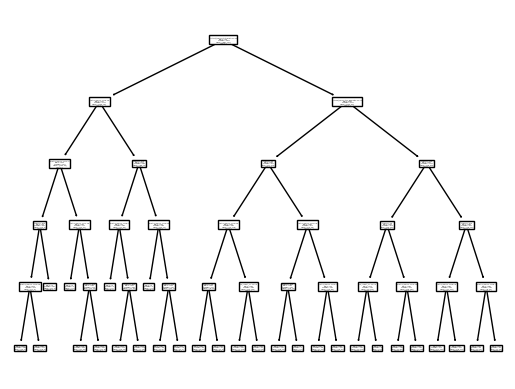

In [84]:
model6 = wr.mr_rogersval(X_train, y_train, X_val, y_val)
model5 = wr.rf_trval_model(X_train, y_train, X_val, y_val)
model4 = wr.df_trval_model(X_train, y_train, X_val, y_val)
model3 = wr.mr_rogerstest(X_train, y_train, X_test, y_test)
model2 = wr.rf_trtest_model(X_train, y_train, X_test, y_test)
model1 = wr.df_trtest_model(X_train, y_train, X_test, y_test)

## Choose Your Fighter:

#### Model 1: DecisionTree
- max_depth=5
- Test Accuracy: 78.35%
- Train Accuracy: 79.20%

#### Model 2: Random Forest
- max_depth= 5
- min_sample_leaf= 3
- Val Accuracy: 79.63%
- Train Accuracy: 79.73%

#### Model 3: KNeighbor
- n_neighbors = 15
- Test Accuracy: 79.49%
- Train Accuracy: 80.24%

#### Model 4: Decision Tree (Train/val)
- max_depth= 5
- Val Accuracy: 79.30%
- Train Accuracy: 80.02%

#### Model 5: Random Forest (Train/val)
- max_depth= 5
- min_sample_leaf= 6
- Val Accuracy: 79.66%
- Train Accuracy: 79.76%

#### Model 6: KNeighbor (Train/val)
- n_neighbors = 24
- Val Accuracy: 78.77%
- Train Accuracy: 80.07%


#### Observations:
- All of my models are performing at at least 78% on my train data.

- I ran 2 Decision Tree models: 1 for train/test, 1 for train/val. On both sets, the max depth of 5 produced the best results

- My random forest models also both used the same max_depths for my top performing models. My train/val sets produced slightly higher results and had 6 sample leaves rather than 3.

- Both my KNN train/test and train/val models had the highest overall train accuracy scores

- Model 5:Random Forest returned the highest validation accuracy score of my 3 train/val sets. It also had the least amount of variance in my train/val sets, as well as the highest recall score of 93%. I'll continue with this model.


## Predictions

Next step: create a csv file that predicts churn probability using my best model

In [112]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=6, random_state=123)
rf.fit(X_train, y_train)
# Make a new dataframe
telco_preds= pd.DataFrame(rf.predict_proba(X_val))

# Make customer id column from validate dataset
telco_preds['customer_id']= pd.Series(val['customer_id'].to_list())

telco_preds['prediction'] = rf.predict(X_val)

# pd.concat('customer_id','prediction','stay','churn')

In [113]:
telco_preds.head()

,0,1,customer_id,prediction
0,0.308452,0.691548,1062-LHZOD,1
1,0.932340,0.067660,8205-OTCHB,0
2,0.625728,0.374272,6173-GOLSU,0
3,0.960580,0.039420,7817-OMJNA,0
4,0.347520,0.652480,0702-PGIBZ,1


In [114]:
predictions = telco_preds.rename(columns= {0: 'stay', 1: 'churn'})

In [115]:
predictions.head()

,stay,churn,customer_id,prediction
0,0.308452,0.691548,1062-LHZOD,1
1,0.932340,0.067660,8205-OTCHB,0
2,0.625728,0.374272,6173-GOLSU,0
3,0.960580,0.039420,7817-OMJNA,0
4,0.347520,0.652480,0702-PGIBZ,1


In [117]:
predictions = predictions[['customer_id', 'prediction', 'stay', 'churn']]
predictions

,customer_id,prediction,stay,churn
0,1062-LHZOD,1,0.308452,0.691548
1,8205-OTCHB,0,0.932340,0.067660
2,6173-GOLSU,0,0.625728,0.374272
3,7817-OMJNA,0,0.960580,0.039420
4,0702-PGIBZ,1,0.347520,0.652480
...,...,...,...,...
1686,6352-GIGGQ,0,0.955750,0.044250
1687,2332-EFBJY,0,0.834621,0.165379
1688,0856-NAOES,0,0.759481,0.240519
1689,8690-UPCZI,0,0.935282,0.064718


In [118]:
# Convert to csv
predictions.to_csv("predictions.csv")

*** Closing remarks/recommendations in final report***